# Building an AlexNet for MNIST Classification

This notebook is for the blog: [Building an AlexNet for MNIST Classification](https://derekzhouai.github.io/posts/building-alexnet-for-mnist/)

## Data Preparation

In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),    # Upscale 28x28 → 224x224
    transforms.ToTensor()
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [3]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [4]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 60000
Number of test samples: 10000


In [5]:
for X, y in train_loader:
    print(f"X.shape: {X.shape}, y.shape: {y.shape}")
    break

X.shape: torch.Size([128, 1, 224, 224]), y.shape: torch.Size([128])


## Model Architecture

In [6]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),         #1x224x224 → 96x54x54
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),                         #96x54x54 → 96x26x26

            nn.Conv2d(96, 256, kernel_size=5, padding=2),                  #96x26x26 → 256x26x26
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),                         #256x26x26 → 256x12x12

            nn.Conv2d(256, 384, kernel_size=3, padding=1),                 #256x12x12 → 384x12x12
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),                 #384x12x12 → 384x12x12
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),                 #384x12x12 → 256x12x12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),                         #256x12x12 → 256x5x5

            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 4096),  # Adjusted for input size
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.net(x)

## Training Setup

In [7]:
import torch
import torch.optim as optim

device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)

model = AlexNet()
model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

## Training the Model

In [8]:
def train(model, loader, optimizer, loss):
    model.train()
    total_loss = 0.0
    total_correct, total_num = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        y_hat = model(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()

        total_loss += l.item() * X.size(0)
        preds = y_hat.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_num += X.size(0)
    return total_loss / total_num, total_correct / total_num

In [9]:
def evaluate(model, loader, loss):
    model.eval()
    total_loss = 0.0
    total_correct, total_num = 0, 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            
            y_hat = model(X)
            l = loss(y_hat, y)

            total_loss += l.item() * X.size(0)
            preds = y_hat.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_num += X.size(0)
    return total_loss / total_num, total_correct / total_num

In [10]:
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss)
    test_loss, test_acc = evaluate(model, test_loader, loss)
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train (loss: {train_loss:.4f}, acc: {train_acc:.4f}) | "
          f"Test (loss: {test_loss:.4f}, acc: {test_acc:.4f})")

Epoch 1/5: Train (loss: 0.3830, acc: 0.8698) | Test (loss: 0.0659, acc: 0.9790)
Epoch 2/5: Train (loss: 0.0652, acc: 0.9805) | Test (loss: 0.0444, acc: 0.9881)
Epoch 3/5: Train (loss: 0.0509, acc: 0.9853) | Test (loss: 0.0477, acc: 0.9856)
Epoch 4/5: Train (loss: 0.0428, acc: 0.9872) | Test (loss: 0.0404, acc: 0.9890)
Epoch 5/5: Train (loss: 0.0394, acc: 0.9885) | Test (loss: 0.0255, acc: 0.9923)


In [13]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 46764746
Trainable parameters: 46764746


## Evaluation

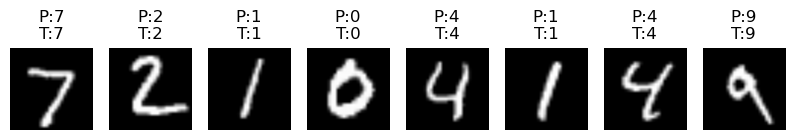

In [11]:
import matplotlib.pyplot as plt

X, y = next(iter(test_loader))
X, y = X[:8], y[:8]
pred = model(X.to(device)).argmax(1).cpu()

plt.figure(figsize=(10,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X[i].squeeze(), cmap="gray")
    plt.title(f"P:{pred[i].item()}\nT:{y[i].item()}")
    plt.axis("off")
plt.show()